
Do không gian trạng thái của Mini Tetris 8×12 là quá lớn (board 8×12 với nhiều loại khối), việc áp dụng Value Iteration trực tiếp lên ma trận board là không khả thi. Vì vậy, nhóm xây dựng một mô hình MDP xấp xỉ với state được rút gọn từ board:
aggregate height (tổng chiều cao các cột),
max height (chiều cao lớn nhất),
number of holes (số lỗ),
bumpiness (độ gồ ghề giữa các cột).
Các đại lượng này được lượng hóa thành một số khoảng (bins) để tạo ra state rời rạc. Giá trị trạng thái được xấp xỉ bằng Value Iteration:
V
(
s
)
←
max
⁡
a
[
r
+
γ
V
(
s
′
)
]
V(s)←
a
max
​
 [r+γV(s
′
 )]
với
s=ϕ(board),
s
′
 =ϕ(board
′
 ).

Môi trường Tetris được dùng như một mô hình sinh mẫu (generative model): tại mỗi bước, chúng em clone trạng thái môi trường, thử tất cả action, nhận
r,s ′ và cập nhật
V(s) theo công thức trên. Sau đó, agent chọn action tham lam theo V (greedy), kết hợp với một tỷ lệ nhỏ action ngẫu nhiên để khám phá thêm trạng thái mới.

Kết quả thực nghiệm cho thấy Value Iteration với trạng thái rút gọn chơi tốt hơn random agent: số bước trung bình trước khi game over và số dòng xoá trung bình đều tăng lên, đồng thời hành vi quan sát trực quan “có chiến lược” hơn (ít tạo holes, hạn chế chiều cao cột, sử dụng xoay và soft-drop hợp lý)



In [2]:
import numpy as np

# Hành động: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
ACTIONS = [0, 1, 2, 3]
ACTION_NAMES = {
    0: "UP",
    1: "RIGHT",
    2: "DOWN",
    3: "LEFT"
}

class Gridworld4x4:
    def __init__(self, gamma=0.99):
        self.H = 4
        self.W = 4
        self.nS = self.H * self.W   # số state
        self.nA = len(ACTIONS)
        self.gamma = gamma

        # terminal states: (0,0) và (3,3)
        self.terminal_states = [0, self.idx(3,3)]

    def idx(self, r, c):
        return r * self.W + c

    def coord(self, s):
        return divmod(s, self.W)  # (row, col)

    def step(self, s, a):
        """
        Trả về (s', reward, done)
        Reward:
          - -1 mỗi bước
          - 0 nếu vào terminal
        """
        if s in self.terminal_states:
            return s, 0.0, True

        r, c = self.coord(s)
        if a == 0 and r > 0:          # UP
            r -= 1
        elif a == 1 and c < self.W-1: # RIGHT
            c += 1
        elif a == 2 and r < self.H-1: # DOWN
            r += 1
        elif a == 3 and c > 0:        # LEFT
            c -= 1

        s_next = self.idx(r, c)

        if s_next in self.terminal_states:
            return s_next, 0.0, True
        else:
            return s_next, -1.0, False


In [3]:
def value_iteration(env, theta=1e-6, max_iter=1000):
    """
    Value Iteration cho Gridworld:
      V_{k+1}(s) = max_a E[ r + gamma V_k(s') ]
    """
    V = np.zeros(env.nS)
    for it in range(max_iter):
        delta = 0.0
        for s in range(env.nS):
            if s in env.terminal_states:
                continue

            v_old = V[s]
            q_values = []

            for a in ACTIONS:
                s_next, r, done = env.step(s, a)
                q = r + env.gamma * V[s_next]
                q_values.append(q)

            V[s] = max(q_values)
            delta = max(delta, abs(v_old - V[s]))

        # kiểm tra hội tụ
        if delta < theta:
            print(f"[Value Iteration] Converged after {it+1} iterations")
            break

    # trích xuất policy greedy từ V
    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        if s in env.terminal_states:
            policy[s] = 0
            continue

        q_values = []
        for a in ACTIONS:
            s_next, r, done = env.step(s, a)
            q = r + env.gamma * V[s_next]
            q_values.append(q)
        best_a = int(np.argmax(q_values))
        policy[s] = best_a

    return V, policy


In [4]:
def policy_evaluation(env, policy, theta=1e-6, max_iter=1000):
    """
    Đánh giá giá trị V^pi với policy cho trước (iterative policy evaluation)
    """
    V = np.zeros(env.nS)
    for it in range(max_iter):
        delta = 0.0
        for s in range(env.nS):
            if s in env.terminal_states:
                continue

            v_old = V[s]
            a = policy[s]
            s_next, r, done = env.step(s, a)
            V[s] = r + env.gamma * V[s_next]
            delta = max(delta, abs(v_old - V[s]))

        if delta < theta:
            break
    return V

def policy_iteration(env, max_iter=100):
    """
    Policy Iteration:
      1. Khởi tạo policy ngẫu nhiên
      2. Policy Evaluation
      3. Policy Improvement
      4. Lặp cho đến khi policy không đổi
    """

    policy = np.random.choice(ACTIONS, size=env.nS)

    for it in range(max_iter):
        V = policy_evaluation(env, policy)

        policy_stable = True
        for s in range(env.nS):
            if s in env.terminal_states:
                continue

            old_a = policy[s]

            q_values = []
            for a in ACTIONS:
                s_next, r, done = env.step(s, a)
                q = r + env.gamma * V[s_next]
                q_values.append(q)
            best_a = int(np.argmax(q_values))
            policy[s] = best_a

            if best_a != old_a:
                policy_stable = False

        print(f"[Policy Iteration] Iter {it+1}, stable={policy_stable}")
        if policy_stable:
            print(f"[Policy Iteration] Converged after {it+1} iterations")
            break

    return V, policy


In [5]:
def print_value_table(env, V):
    print("State values (reshape 4x4):")
    print(V.reshape(env.H, env.W))

def print_policy(env, policy):
    # in mũi tên ↑ → ↓ ← thay cho số
    arrows = {0:"↑", 1:"→", 2:"↓", 3:"←"}
    grid = []
    for s in range(env.nS):
        if s in env.terminal_states:
            grid.append("T")
        else:
            grid.append(arrows[policy[s]])
    grid = np.array(grid).reshape(env.H, env.W)
    print("Policy:")
    for r in range(env.H):
        print(" ".join(grid[r]))


In [6]:
env_gw = Gridworld4x4(gamma=0.99)

# Value Iteration
V_vi, pi_vi = value_iteration(env_gw)
print("Value Iteration")
print_value_table(env_gw, V_vi)
print_policy(env_gw, pi_vi)

# Policy Iteration
V_pi, pi_pi = policy_iteration(env_gw)
print("\nPolicy Iteration")
print_value_table(env_gw, V_pi)
print_policy(env_gw, pi_pi)


[Value Iteration] Converged after 3 iterations
=== Value Iteration ===
State values (reshape 4x4):
[[ 0.    0.   -1.   -1.99]
 [ 0.   -1.   -1.99 -1.  ]
 [-1.   -1.99 -1.    0.  ]
 [-1.99 -1.    0.    0.  ]]
Policy:
T ← ← ↓
↑ ↑ ↑ ↓
↑ ↑ → ↓
↑ → → T
[Policy Iteration] Iter 1, stable=False
[Policy Iteration] Iter 2, stable=False
[Policy Iteration] Iter 3, stable=False
[Policy Iteration] Iter 4, stable=True
[Policy Iteration] Converged after 4 iterations

=== Policy Iteration ===
State values (reshape 4x4):
[[ 0.    0.   -1.   -1.99]
 [ 0.   -1.   -1.99 -1.  ]
 [-1.   -1.99 -1.    0.  ]
 [-1.99 -1.    0.    0.  ]]
Policy:
T ← ← ↓
↑ ↑ ↑ ↓
↑ ↑ → ↓
↑ → → T


heatmap với tham số cố định gamma=0.99, step rw=--1, term rw=0

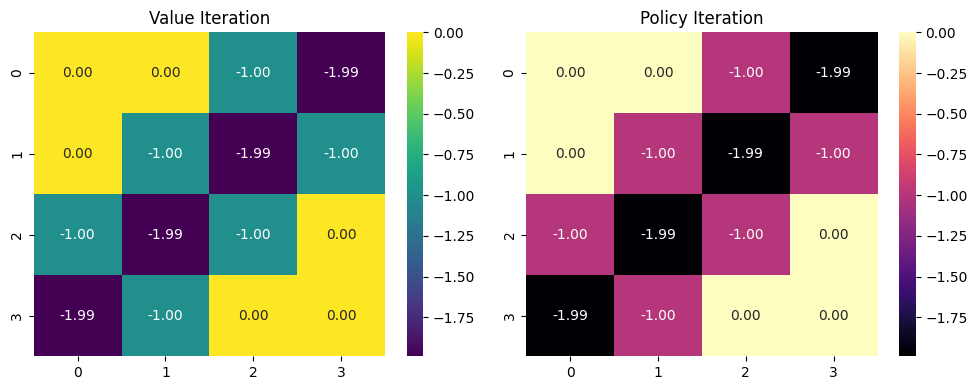

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Heatmap for Value Iteration ---
sns.heatmap(V_vi.reshape(4,4), annot=True, cmap="viridis", fmt=".2f",
            ax=axes[0])
axes[0].set_title("Value Iteration")

# --- Heatmap for Policy Iteration ---
sns.heatmap(V_pi.reshape(4,4), annot=True, cmap="magma", fmt=".2f",
            ax=axes[1])
axes[1].set_title("Policy Iteration")

plt.tight_layout()
plt.show()



thay tham số

    gamma  step_reward  terminal_reward  VI_iters  PI_iters  V(1,1)_VI  \
0    0.50        -1.00                0         3         4      -1.00   
1    0.50        -1.00                5         3         4       1.50   
2    0.50        -0.10                0         3         4      -0.10   
3    0.50        -0.10                5         3         4       2.40   
4    0.50        -0.01                0         3         4      -0.01   
5    0.50        -0.01                5         3         4       2.49   
6    0.80        -1.00                0         3         4      -1.00   
7    0.80        -1.00                5         3         4       3.00   
8    0.80        -0.10                0         3         4      -0.10   
9    0.80        -0.10                5         3         4       3.90   
10   0.80        -0.01                0         3         4      -0.01   
11   0.80        -0.01                5         3         4       3.99   
12   0.90        -1.00                

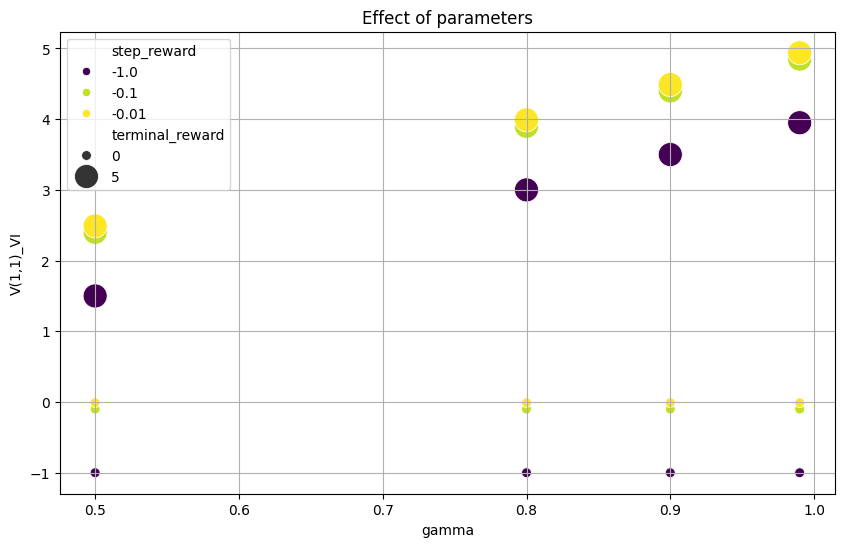

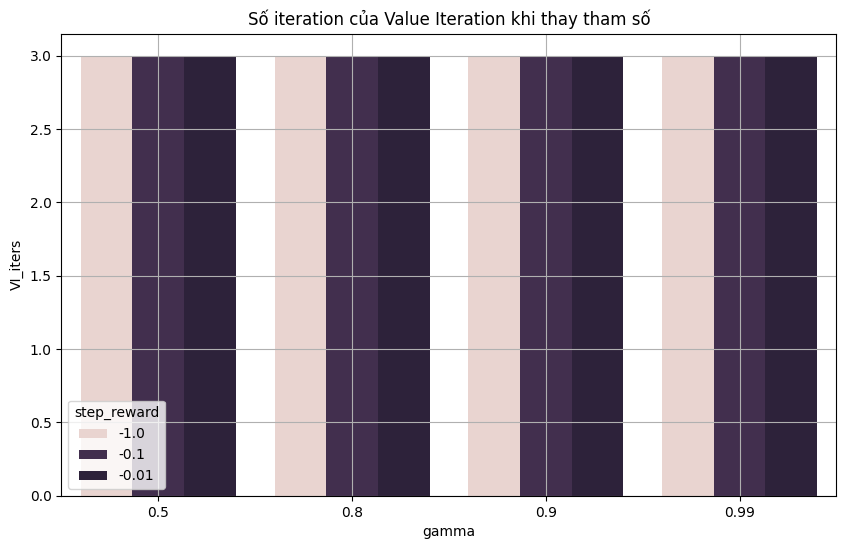

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ACTIONS = [0,1,2,3]

class Gridworld4x4:
    def __init__(self, gamma=0.99, step_reward=-1.0, terminal_reward=0.0):
        self.H = 4
        self.W = 4
        self.nS = self.H * self.W
        self.nA = len(ACTIONS)

        self.gamma = gamma
        self.step_reward = step_reward
        self.terminal_reward = terminal_reward

        self.terminal_states = [0, self.idx(3,3)]

    def idx(self, r, c):
        return r*self.W + c

    def coord(self, s):
        return divmod(s, self.W)

    def step(self, s, a):
        if s in self.terminal_states:
            return s, self.terminal_reward, True

        r, c = self.coord(s)

        if a == 0 and r > 0: r -= 1
        elif a == 1 and c < self.W-1: c += 1
        elif a == 2 and r < self.H-1: r += 1
        elif a == 3 and c > 0: c -= 1

        s_next = self.idx(r,c)

        if s_next in self.terminal_states:
            return s_next, self.terminal_reward, True

        return s_next, self.step_reward, False

#VI
def value_iteration_with_iters(env, theta=1e-6, max_iter=200):
    V = np.zeros(env.nS)
    iters = 0

    for it in range(max_iter):
        delta = 0
        for s in range(env.nS):
            if s in env.terminal_states:
                continue
            q_values = []
            for a in ACTIONS:
                s_next, r, done = env.step(s, a)
                q_values.append(r + env.gamma * V[s_next])
            v_new = max(q_values)
            delta = max(delta, abs(V[s] - v_new))
            V[s] = v_new

        iters = it + 1
        if delta < theta:
            break

    return V, iters


#PI
def policy_evaluation(env, policy, theta=1e-6, max_iter=200):
    V = np.zeros(env.nS)
    for it in range(max_iter):
        delta = 0
        for s in range(env.nS):
            if s in env.terminal_states:
                continue
            a = policy[s]
            s_next, r, done = env.step(s, a)
            v_new = r + env.gamma * V[s_next]
            delta = max(delta, abs(v_new - V[s]))
            V[s] = v_new
        if delta < theta:
            break
    return V

def policy_iteration_with_iters(env, max_iter=200):
    policy = np.random.choice(ACTIONS, size=env.nS)
    iters = 0

    for it in range(max_iter):
        V = policy_evaluation(env, policy)
        stable = True

        for s in range(env.nS):
            if s in env.terminal_states:
                continue

            old = policy[s]
            q_values = []
            for a in ACTIONS:
                s_next, r, done = env.step(s, a)
                q_values.append(r + env.gamma * V[s_next])

            best = int(np.argmax(q_values))
            policy[s] = best
            if best != old:
                stable = False

        iters = it + 1
        if stable:
            break

    return V, iters

#SWEEP
def run_sweep(gamma_list, step_reward_list, terminal_reward_list):
    rows = []

    for g in gamma_list:
        for sr in step_reward_list:
            for tr in terminal_reward_list:

                env = Gridworld4x4(gamma=g, step_reward=sr, terminal_reward=tr)

                V_vi, it_vi = value_iteration_with_iters(env)
                V_pi, it_pi = policy_iteration_with_iters(env)

                mid_state = 5

                rows.append({
                    "gamma": g,
                    "step_reward": sr,
                    "terminal_reward": tr,
                    "VI_iters": it_vi,
                    "PI_iters": it_pi,
                    "V(1,1)_VI": V_vi[mid_state],
                    "V(1,1)_PI": V_pi[mid_state],
                })

    return pd.DataFrame(rows)


#CHANGE
gamma_list = [0.5, 0.8, 0.9, 0.99]
step_list = [-1, -0.1, -0.01]
terminal_list = [0, +5]

df = run_sweep(gamma_list, step_list, terminal_list)
print(df)


#PLOT
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="gamma", y="V(1,1)_VI",
                size="terminal_reward", hue="step_reward",
                palette="viridis", sizes=(50, 300))
plt.title("Effect of parameters")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=df, x="gamma", y="VI_iters", hue="step_reward")
plt.title("Số iteration của Value Iteration khi thay tham số")
plt.grid(True)
plt.show()


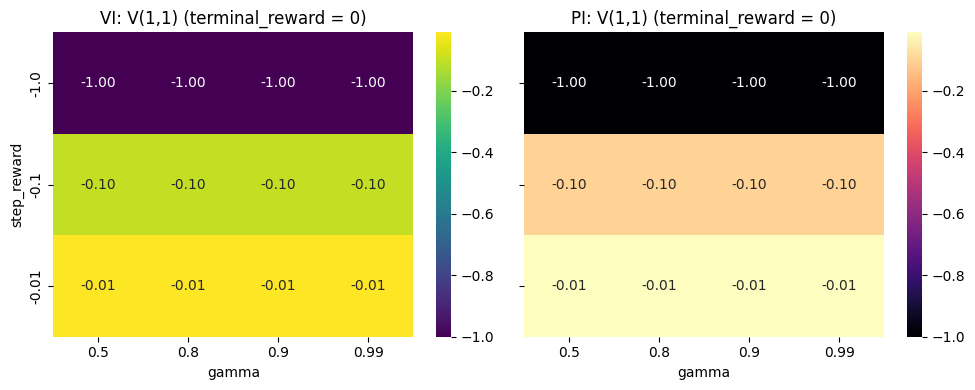

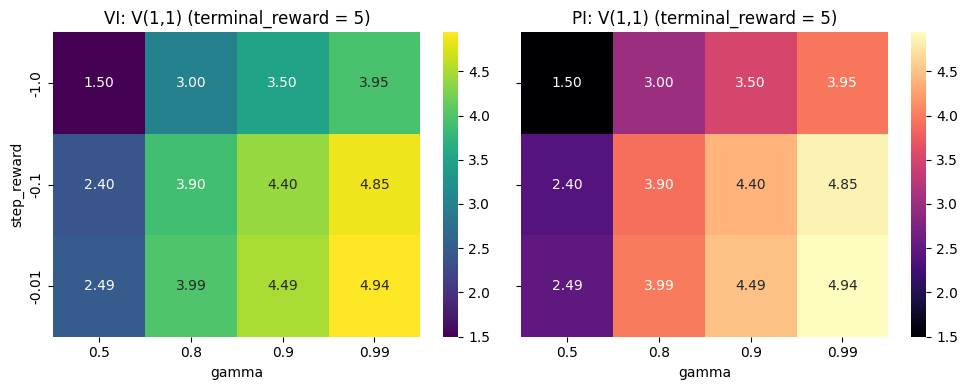

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

for tr in sorted(df["terminal_reward"].unique()):
    df_tr = df[df["terminal_reward"] == tr]

    # pivot cho VI và PI
    pivot_vi = df_tr.pivot(index="step_reward",
                           columns="gamma",
                           values="V(1,1)_VI")
    pivot_pi = df_tr.pivot(index="step_reward",
                           columns="gamma",
                           values="V(1,1)_PI")

    vmin = min(pivot_vi.min().min(), pivot_pi.min().min())
    vmax = max(pivot_vi.max().max(), pivot_pi.max().max())

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    sns.heatmap(pivot_vi, annot=True, fmt=".2f", cmap="viridis",
                vmin=vmin, vmax=vmax, ax=axes[0])
    axes[0].set_title(f"VI: V(1,1) (terminal_reward = {tr})")
    axes[0].set_xlabel("gamma")
    axes[0].set_ylabel("step_reward")

    sns.heatmap(pivot_pi, annot=True, fmt=".2f", cmap="magma",
                vmin=vmin, vmax=vmax, ax=axes[1])
    axes[1].set_title(f"PI: V(1,1) (terminal_reward = {tr})")
    axes[1].set_xlabel("gamma")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()


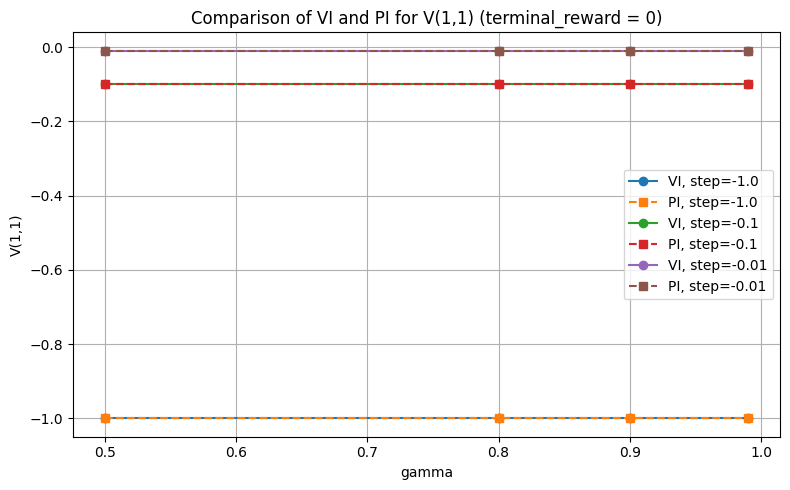

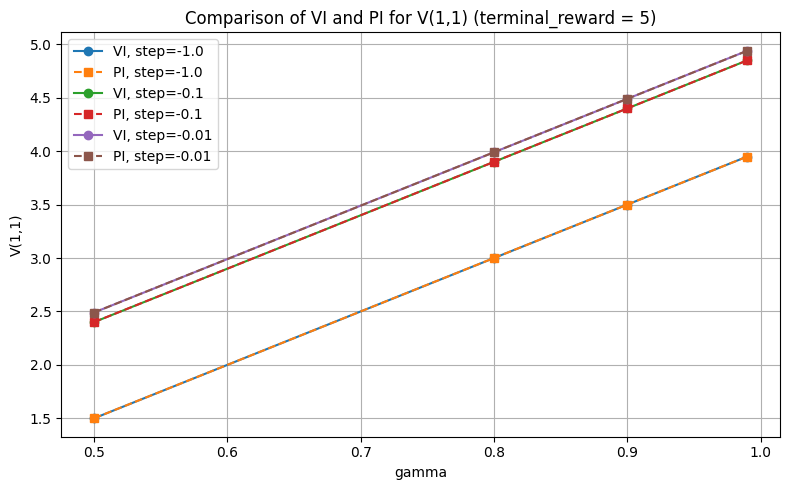

In [24]:
import matplotlib.pyplot as plt

for tr in sorted(df["terminal_reward"].unique()):
    df_tr = df[df["terminal_reward"] == tr]

    plt.figure(figsize=(8,5))
    for sr in sorted(df_tr["step_reward"].unique()):
        df_sub = df_tr[df_tr["step_reward"] == sr].sort_values("gamma")

        # VI: liền, tròn
        plt.plot(df_sub["gamma"], df_sub["V(1,1)_VI"],
                 marker="o", linestyle="-",
                 label=f"VI, step={sr}")

        # PI: đứt, vuông
        plt.plot(df_sub["gamma"], df_sub["V(1,1)_PI"],
                 marker="s", linestyle="--",
                 label=f"PI, step={sr}")

    plt.title(f"Comparison of VI and PI for V(1,1) (terminal_reward = {tr})")
    plt.xlabel("gamma")
    plt.ylabel("V(1,1)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
